## In this notebook, we display how to integrate morphological feature extracted by different models

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

sc.set_figure_params(figsize=(8, 8))
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

### Load data (Human intestine as example)

In [2]:
from pathlib import Path
import json
from matplotlib.image import imread
from h5py import File

path = 'D:/st_projects/data/Intestine/A1'
path = Path(path)
files = dict(
    tissue_positions_file=path / 'spatial/tissue_positions_list.csv',
    scalefactors_json_file=path / 'spatial/scalefactors_json.json',
    hires_image=path / 'spatial/tissue_hires_image.png',
    lowres_image=path / 'spatial/tissue_lowres_image.png',
)

adata = sc.read_h5ad('D:/st_projects/data/Intestine/A1/10X_Visium_fawkner2021spatiotemporal_A1_data.h5ad')
library_id = 'A1'
adata.uns["spatial"] = dict()
adata.uns["spatial"][library_id] = dict()

# check if files exists, continue if images are missing
adata.uns["spatial"][library_id]['images'] = dict()

for res in ['hires', 'lowres']:
    adata.uns["spatial"][library_id]['images'][res] = imread(str(files[f'{res}_image']))
    
adata.uns["spatial"][library_id]['scalefactors'] = json.loads(files['scalefactors_json_file'].read_bytes())

positions = pd.read_csv(files['tissue_positions_file'], header=None)
positions.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]
positions.index = positions['barcode']
adata.obs = adata.obs.join(positions, how="left")

adata.obsm['spatial'] = adata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
adata.obs.drop(columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'], inplace=True,)
display(adata)

AnnData object with n_obs × n_vars = 2649 × 33538
    obs: 'clusters', 'leiden', 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'spatial'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_pixel', 'spatial_real'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

### Visualize marker gene

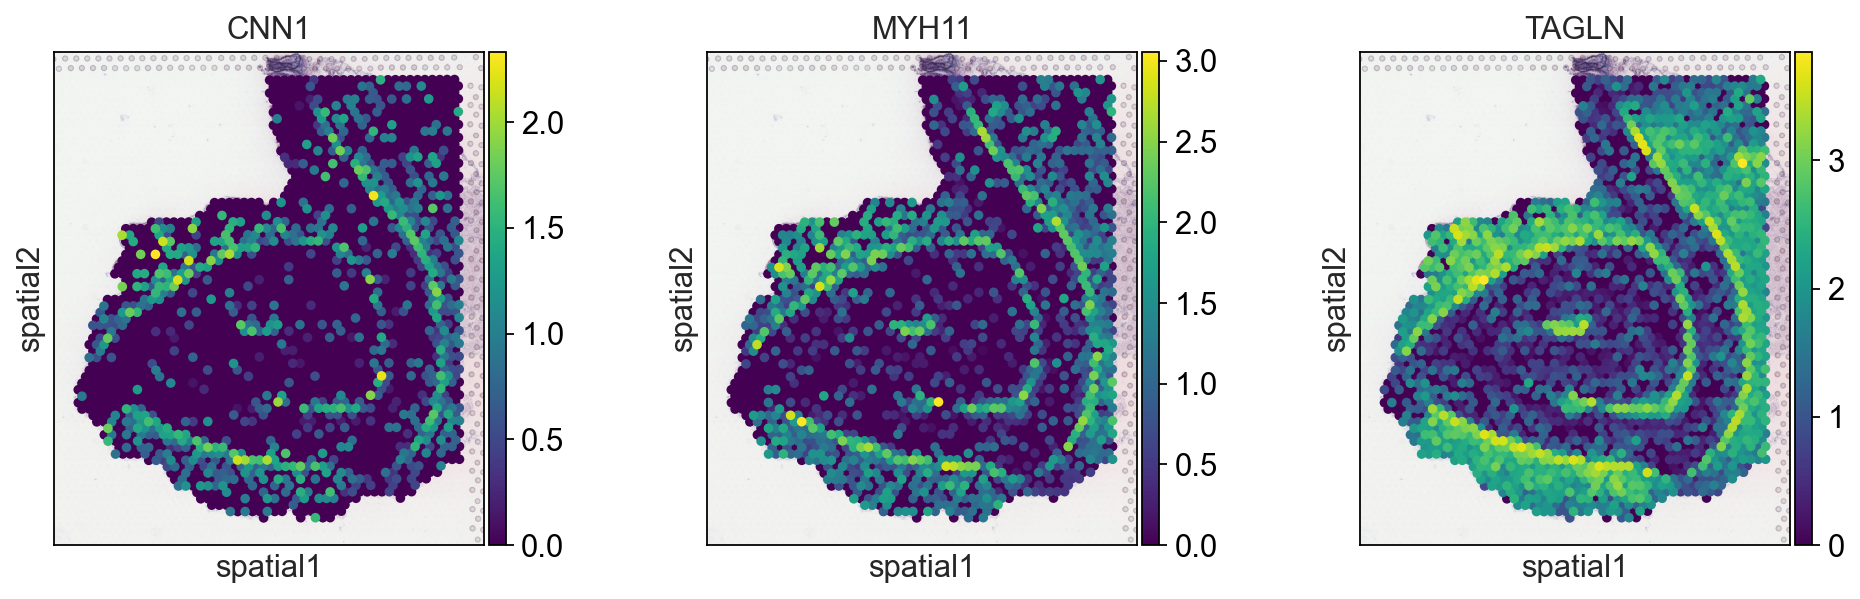

In [3]:
sc.pl.spatial(adata, color=['CNN1', 'MYH11', 'TAGLN'], size=2, color_map='viridis')

### We first crop histology image according to spatial coordinate of spots

In [4]:
from image_feature import image_crop, ImageFeature
import os
section = 'Intestine_A1'

# extract deep image features
# 提取形态学特征
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, save_path=save_path_image_crop, crop_size=56, verbose=False)

Tiling Image: 100%|██████████ [ time left: 00:00 ]


### Here, we display how to extract features using different models (Virchow, UNI, or Prov-GigaPath)

In [5]:
import timm
from timm.layers import SwiGLUPacked
from timm.data.transforms_factory import create_transform
from timm.data import resolve_data_config
from torchvision import transforms
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def load_model(model_name, device):
    if model_name == 'UNI':
        model = timm.create_model("hf-hub:MahmoodLab/uni", pretrained=True, init_values=1e-5, dynamic_img_size=True) # PMID:38504018
    elif model_name == 'GIGA':
        model = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)
    elif model_name == 'Virchow':
        model = timm.create_model('hf-hub:paige-ai/Virchow', pretrained=True, mlp_layer=SwiGLUPacked, act_layer=torch.nn.SiLU) # PMID:39039250
    else:
        raise NotImplementedError(f'Model {model_name} not implemented !')
    
    return model.to(device).eval()

vir_model = load_model('Virchow', device)
vir_model = vir_model.eval()
uni_model = load_model('UNI', device)
giga_model = load_model('GIGA', device)

vir_transform = create_transform(**resolve_data_config(vir_model.pretrained_cfg, model=vir_model))
uni_transform = create_transform(**resolve_data_config(uni_model.pretrained_cfg, model=uni_model))
giga_transform = transforms.Compose(
    [
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
from  PIL import Image

vir_model.tag = 'vir'
uni_model.tag = 'uni'
giga_model.tag = 'giga'

def vis_feature_extract(adata, model, transform, data_frame):
    for spot, slice_path in adata.obs['slice_path'].items():
        spot_slice = Image.open(slice_path).resize((224, 224))
        image = transform(spot_slice).unsqueeze(0).to(device)
        
        with torch.no_grad():
            if model.tag == 'vir':
                feature_emb = model(image)[:, 0]
            else:
                feature_emb = model(image)
            result_npy = feature_emb.data.cpu().numpy().ravel()
            data_frame[spot] = result_npy
        pbar.update(1)

### In this notebook, we use Prov-GigaPath as example

In [7]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

vir_feature_df = pd.DataFrame()
uni_feature_df = pd.DataFrame()
giga_feature_df = pd.DataFrame()

with tqdm(total=len(adata), desc='Extract image feature', bar_format='{l_bar}{bar} [ time left: {remaining} ]') as pbar:
    # vis_feature_extract(adata, vir_model, vir_transform, vir_feature_df)
    # vis_feature_extract(adata, uni_model, uni_transform, uni_feature_df)
    vis_feature_extract(adata, giga_model, giga_transform, giga_feature_df)

Extract image feature: 100%|██████████ [ time left: 00:00 ]


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
adata.obsm['image_feature'] = giga_feature_df.transpose().to_numpy()  # for other models, just set corresponding dataframe
adata.obsm['image_feat_pca'] = pca.fit_transform(giga_feature_df.transpose().to_numpy())

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.23421430587768555 seconds
Jaccard graph constructed in 4.221790552139282 seconds
Wrote graph to binary file in 0.01749277114868164 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784012
After 2 runs, maximum modularity is Q = 0.787546
After 4 runs, maximum modularity is Q = 0.788694
After 5 runs, maximum modularity is Q = 0.791824
Louvain completed 25 runs in 6.0742597579956055 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 13.461878061294556 seconds


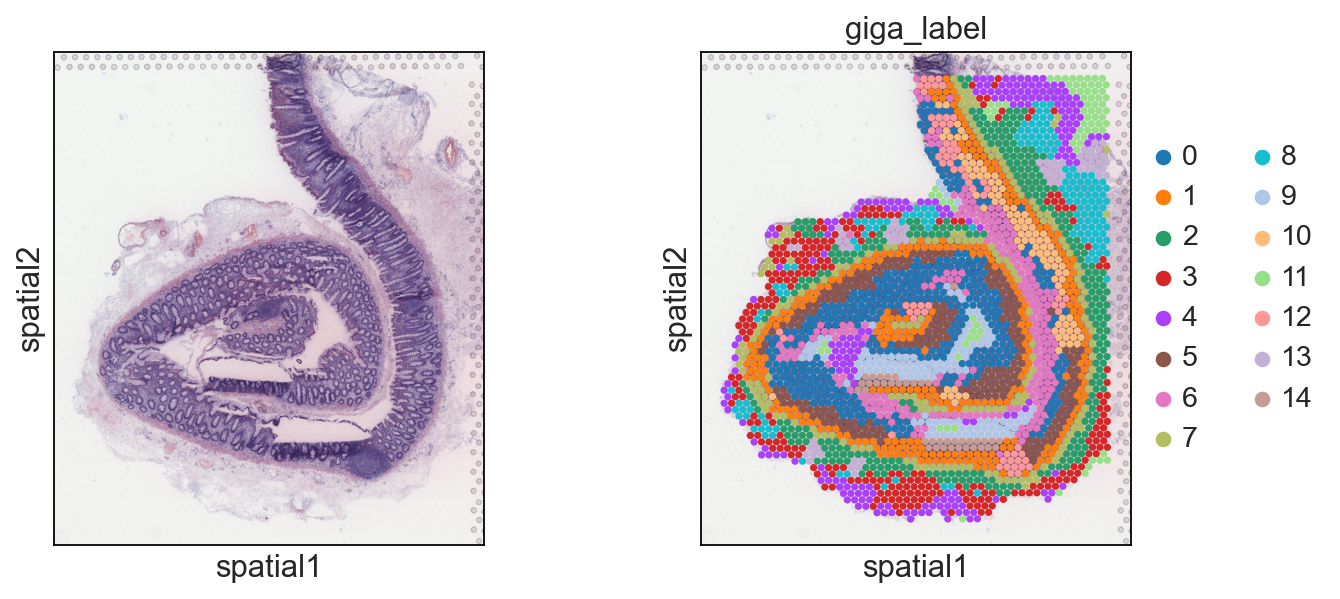

In [10]:
import phenograph

label, _, _ = phenograph.cluster(adata.obsm['image_feat_pca'])
adata.obs['giga_label'] = label
adata.obs['giga_label'] = adata.obs['giga_label'].astype('category')
sc.pl.spatial(adata, color=[None, 'giga_label'], size=1.5)

### Now, we start MuCST to integrate multi-modal features

In [11]:
# transcript-data preprocess
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_genes(adata, min_counts=10)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata

AnnData object with n_obs × n_vars = 2649 × 13000
    obs: 'clusters', 'leiden', 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'slice_path', 'giga_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable_rank', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'clusters_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'spatial', 'giga_label_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_pixel', 'spatial_real', 'image_feature', 'image_feat_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'dis

In [12]:
from utils import construction_interaction
from sklearn.metrics import pairwise_distances

construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

In [16]:
# for histology-specific models, we do not use SimCLR to refine features

adata.obsm['aug_image_feature1'] = adata.obsm['image_feature'].copy()
adata.obsm['aug_image_feature2'] = adata.obsm['image_feature'].copy()

In [13]:
from mucstpy.utils import data_augmentation
from mucstpy.utils import add_contrastive_label, get_feature

data_augmentation(adata)
add_contrastive_label(adata)
get_feature(adata)

In [20]:
from mucstpy.MuCST import train_model

gene_dims = [adata.shape[1], 64]
img_dims = [adata.obsm['image_feature'].shape[1], 64]
proj_dims = [64, 32, 16]

train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=proj_dims, lamb1=2, lamb3=1, device=device)

Begin to train MuCST...


# Epoch 1499, loss: 1.060, g2g_loss: 0.055, gene_recon: 0.843, image_recon: 0.106:  96%|█████████▋| 1495/1550 [00:22<00:00, 64.05it/s]

# Epoch 1500, loss: 27.395, g2g_loss: 0.055, gene_recon: 0.843, image_recon: 0.106
Init finished, start contrastive learning part


# Epoch 1549, loss: 16.820, g2i_loss: 7.950, g2g_loss: 0.577, i2i_loss: 7.579, gene_recon: 0.884, image_recon: 0.174: 100%|██████████| 1550/1550 [00:57<00:00, 27.14it/s] 

Optimization of MuCST finished


In [21]:
from mucstpy.utils import mclust_R, refine_label
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

tool = 'mclust'
radius = 5

mclust_R(adata, used_obsm='fusion_pca', num_cluster=15)
adata.obs['domain'] = adata.obs['mclust']
new_type = refine_label(adata, radius, key='domain')
adata.obs['domain'] = new_type

fitting ...
  |======================================================================| 100%


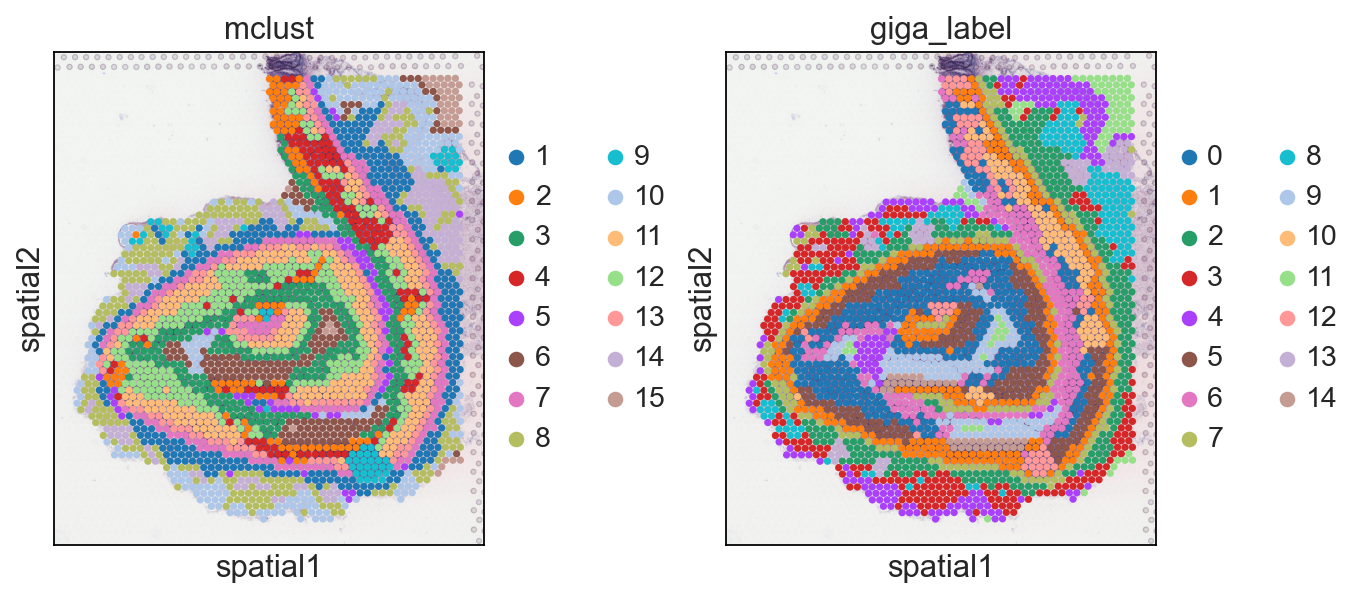

In [23]:
sc.pl.spatial(adata, color=['mclust', 'giga_label'], size=1.5)